## Loading training data

In [124]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import shap
import random

In [16]:
data = pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet")
data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


## Data pre-processing

In [17]:
def bytes_to_image(d):
    if isinstance(d, dict) and "bytes" in d:
        bytes_ls = d["bytes"]
        np_ls = np.frombuffer(bytes_ls, np.uint8)
        image = cv2.imdecode(np_ls, cv2.IMREAD_GRAYSCALE)
        return image
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(d)}")

In [18]:
data["img_arr"] = data["image"].apply(bytes_to_image)
data.drop("image", axis = 1, inplace = True)
data.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [19]:
label_to_class_mapping = {0: "Mild_Demented", 1: "Moderate_Demented", 2: "Non_Demented",3: "Very_Mild_Demented"}
data["class"] = data["label"].map(label_to_class_mapping)
data.head()

,label,img_arr,class
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mild_Demented
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented


## Model training

In [20]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size = 0.2, stratify = data["class"], random_state = 42)

train_data.shape, val_data.shape

((4096, 3), (1024, 3))

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight


X_train = np.stack(train_data["img_arr"].values)
y_train = train_data["label"].values
X_val = np.stack(val_data["img_arr"].values)
y_val = val_data["label"].values

X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)

class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

print(class_weights_dict)

model = models.Sequential([
    layers.Conv2D(128, (3, 3), activation = "relu", input_shape = (128, 128, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation = "relu"),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dense(4, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

early_stop = EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

model.summary()

{0: 1.768566493955095, 1: 26.256410256410255, 2: 0.4987822698490015, 3: 0.7185964912280701}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                              

In [31]:
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_val, y_val), callbacks = [early_stop], class_weight = class_weights_dict)

Epoch 1/50
128/128 [==============================] - 277s 2s/step - loss: 3.5695 - accuracy: 0.2820 - val_loss: 1.0788 - val_accuracy: 0.5010
Epoch 2/50
128/128 [==============================] - 264s 2s/step - loss: 1.3014 - accuracy: 0.3706 - val_loss: 1.3107 - val_accuracy: 0.3447
Epoch 3/50
128/128 [==============================] - 263s 2s/step - loss: 1.1109 - accuracy: 0.4143 - val_loss: 1.1592 - val_accuracy: 0.4229
Epoch 4/50
128/128 [==============================] - 268s 2s/step - loss: 0.9467 - accuracy: 0.4648 - val_loss: 1.0805 - val_accuracy: 0.4951


In [35]:
model.save("cnn_model.keras")

## SHAP model explainability

<Figure size 2000x2000 with 0 Axes>

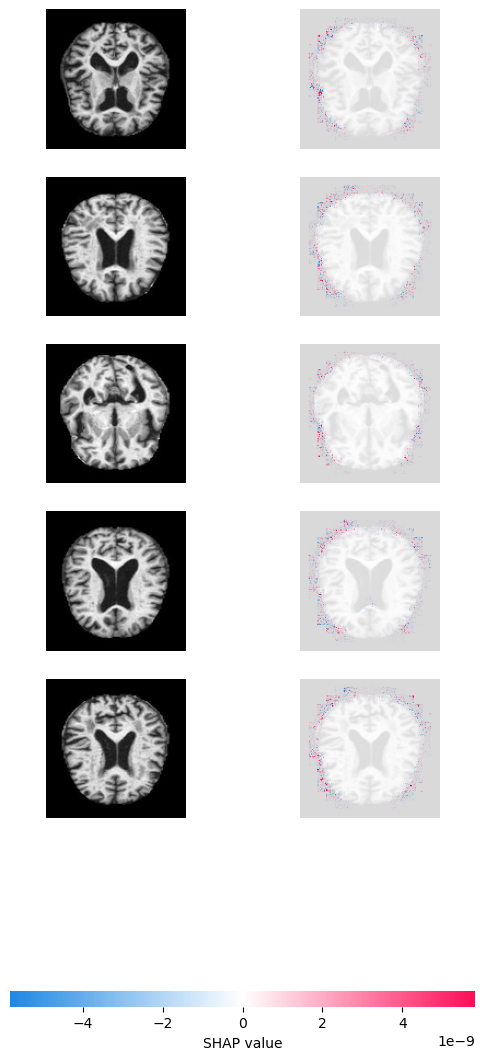

In [97]:
shap_background = X_train[np.random.choice(X_train.shape[0], 100, replace = False)]
test_data = X_val[:4]
true_labels = y_val[:4]

model_explainer = shap.GradientExplainer(model, shap_background)
shap_values = model_explainer.shap_values(test_data)

plt.figure(figsize = (20, 20))

shap.image_plot(shap_values, test_data, show = False)

plt.show()

## SmoothGrad model explainability

In [93]:
def compute_smoothgrad(model, img, class_index = None, num_samples = 50, noise_level = 0.15):
    if (isinstance(img, np.ndarray)):
        img = tf.convert_to_tensor(img, dtype = tf.float32)

    if (len(img.shape) == 3):
        img = tf.expand_dims(img, 0)

    if (class_index is None):
        preds = model(img)[0]
        class_index = tf.argmax(preds).numpy()

    grads_list = []

    for i in range(num_samples):
        noise = noise_level * tf.random.normal(shape = img.shape)
        noisy_img = img + noise

        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            preds = model(noisy_img)
            loss = preds[:, class_index]

        grads = tape.gradient(loss, noisy_img)[0]
        grads_list.append(grads.numpy())

    smoothgrad = np.mean(grads_list, axis=0)

    if (smoothgrad.ndim == 3 and smoothgrad.shape[-1] > 1):
        smoothgrad = smoothgrad.mean(axis = -1)

    smoothgrad_norm = (smoothgrad - smoothgrad.min()) / (smoothgrad.max() - smoothgrad.min() + 1e-9)

    return smoothgrad_norm

1/1 [==============================] - 0s 357ms/step


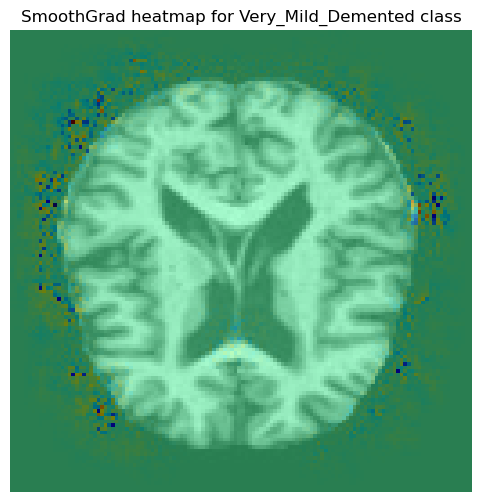

1/1 [==============================] - 0s 326ms/step


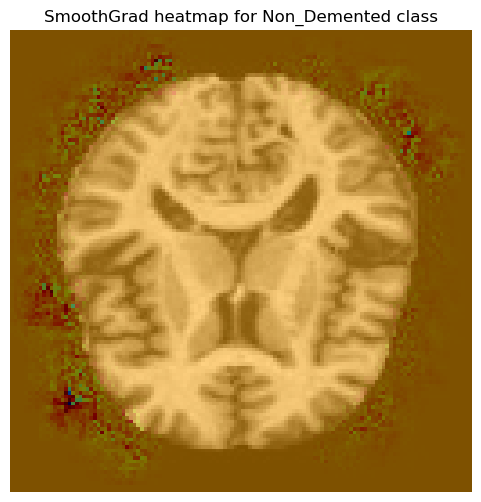

1/1 [==============================] - 0s 343ms/step


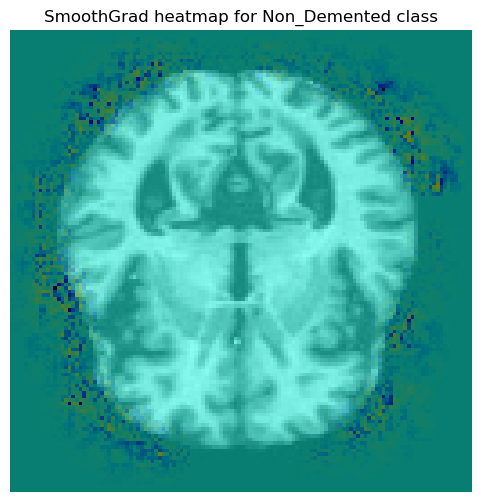

1/1 [==============================] - 0s 246ms/step


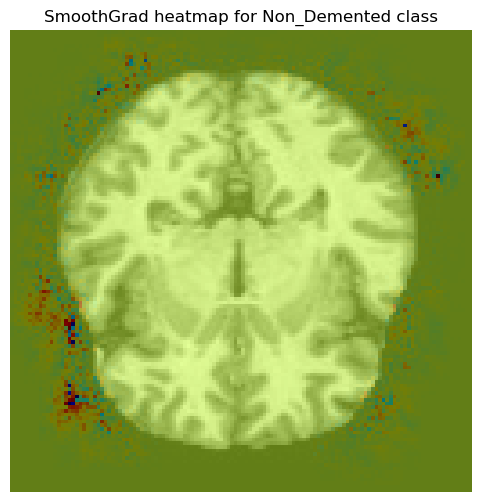

In [126]:
ls = [random.randint(0, 1024) for i in range(4)]

for i in ls:
    img = X_val[i]

    preds = model.predict(img[np.newaxis])[0]
    pred_class = np.argmax(preds)
    
    heatmap = compute_smoothgrad(model, img, class_index = pred_class)
    
    plt.figure(figsize = (6, 6))
    plt.imshow(img.squeeze(), cmap = "gray")
    plt.imshow(heatmap, cmap = "jet", alpha = 0.5)
    plt.title(f"SmoothGrad heatmap for {label_to_class_mapping[pred_class]} class")
    plt.axis("off")
    plt.show()